# **Encoder-Decoder LSTM**

In [ ]:
!pip install muspy

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
import muspy
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as rnn_utils

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")

Using device: cuda
GPU Name: NVIDIA L4
Memory Allocated: 0.0 GB
Memory Cached: 0.0 GB


In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
metadata = pd.read_csv("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0.csv")

Again, after the imports and devices are prepared, it's time to load the datatsets. They are the same as the ones used in the Many-to-many setup.

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, metadata, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.songs = []

        for file in metadata["midi_filename"]:
            file_path = os.path.join("/content/drive/MyDrive/Piano generation/Project/MAESTRO dataset/maestro-v3.0.0-midi/maestro-v3.0.0/", file)
            muspy_file = muspy.read(file_path)
            self.songs.append(muspy_file)

    def __len__(self):
        return len(self.songs)

    def __getitem__(self, idx):
        pianoroll_song = self.songs[idx].to_pianoroll_representation()
        pianoroll_song = torch.tensor(pianoroll_song, dtype=torch.float32)

        start_idx = random.randint(0, len(pianoroll_song) - 2 * self.seq_len)

        input_seq = pianoroll_song[start_idx:start_idx+self.seq_len]

        target = pianoroll_song[start_idx+(self.seq_len // 2) : start_idx+self.seq_len+(self.seq_len // 2)]

        return input_seq, target

In [ ]:
music_dataset_train = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/train/music_dataset_train_many_to_many_muspy.pt", weights_only=False)
music_dataset_val = torch.load("/content/drive/MyDrive/Piano generation/Project/saved_data/datasets/validation/music_dataset_val_many_to_many_muspy.pt", weights_only=False)

Here we define our encoder. It's comprised only of bi-directional LSTM layers. The forward method takes the forward and backward hidden states, calculates their sum and then returns that sum.


In [ ]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        _, (h_n, c_n) = self.lstm(x)]

        h_n = h_n.view(self.num_layers, 2, x.size(0), self.hidden_size)
        c_n = c_n.view(self.num_layers, 2, x.size(0), self.hidden_size)

        h_n = h_n.sum(dim=1)
        c_n = c_n.sum(dim=1)

        return h_n, c_n

Here is the architecture of a decoder. It consists of several LSTM layers and one linear layer to map them onto a 128-dimensional vector. The forward method expects an input sequence, as well as hidden states and returns the output, as well as the new hidden states.

In [ ]:
class DecoderLSTM(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True)
        self.ff = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_n, c_n):
        output, (h_n, c_n) = self.lstm(x, (h_n, c_n))
        output = self.ff(output)
        return output, h_n, c_n

The encoder and the decoder are combined into a single model, called Seq2SeqLSTM. It takes the input sequence, passes it through the encoder and then uses the encoder output to pass it to the decoder. The decoder goes into a "decoding loop" where it genrates tones one at a time until it reaches the desired length.


In [ ]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, target_seq_len, teacher_forcing_ratio=0.5):
        batch_size = x.size(0)
        output_size = self.decoder.ff.out_features
        outputs = torch.zeros(batch_size, target_seq_len, output_size).to(x.device)

        h_n, c_n = self.encoder(x)

        decoder_input = torch.zeros(batch_size, 1, output_size).to(x.device)

        for t in range(target_seq_len):
            output, h_n, c_n = self.decoder(decoder_input, h_n, c_n)
            outputs[:, t, :] = output.squeeze(1)

            if torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = x[:, t, :].unsqueeze(1)
            else:
                decoder_input = output

        return outputs

In [ ]:
def collate_fn(batch):
    sequences, targets = zip(*batch)

    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)  # Pad with 0 for piano roll
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)    # Pad with 0 for targets

    return sequences_padded, targets_padded

In [ ]:
music_dataloader_train = DataLoader(music_dataset_train, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, collate_fn=collate_fn)
music_dataloader_val = DataLoader(music_dataset_val, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, collate_fn=collate_fn)

Here, we initialize both the encoder and the decoder with a hidden size of 1024 in order to try and capture more complex structures. The input and output sizes stay 128, because that's what the data requires and the layers remain 2.


In [ ]:
encoder = EncoderLSTM(input_size=128, hidden_size=1024, num_layers=2)
decoder = DecoderLSTM(output_size=128, hidden_size=1024, num_layers=2)

model = Seq2SeqLSTM(encoder, decoder).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

This is the train function. It's really similar to the one used in the Many-to-One models, but this time, a scheduler was added. The scheduler, that is used here watches if the loss becomes stagnant and decreases the learning rate by a half.

Also, the encoder-decoder architecture uses teacher forcing, which begins at a rate of 0.7 and decreases as the epochs go down, becoming a constant 0.1 after 60 epochs. This helps the model not go too far from the original sequence in the early stages of training.

In [ ]:
def train_seq2seq_lstm(model, optimizer, criterion, num_epochs, train_loss_history=[], val_loss_history=[], create_plot=True):
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    for epoch in range(num_epochs):
        train_total_loss = 0.0

        teacher_forcing_ratio = max(0.7 - len(train_loss_history) * 0.01, 0.1)

        for inputs, targets in tqdm(music_dataloader_train, f"Epoch {len(train_loss_history)+1}:"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs, target_seq_len=targets.shape[1], teacher_forcing_ratio=teacher_forcing_ratio)

            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            train_total_loss += loss.item()

        train_avg_loss = train_total_loss / len(music_dataloader_train)
        train_loss_history.append(train_avg_loss)
        print("Average Train Loss:", train_avg_loss)

        scheduler.step(train_avg_loss)

        if ((len(train_loss_history)+1) % 10) == 0:
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Piano generation/Project/saved_data/saved_models/encoder_decoder_lstm_epoch_{len(train_loss_history)+1}.pt")

        model.eval()
        val_total_loss = 0.0

        for inputs, targets in music_dataloader_val:
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.no_grad():
                outputs = model(inputs, target_seq_len=targets.shape[1])

                loss = criterion(outputs, targets)
                val_total_loss += loss.item()

        val_avg_loss = val_total_loss / len(music_dataloader_val)
        val_loss_history.append(val_avg_loss)
        print("Average Validation Loss:", val_avg_loss)
        model.train()

    if create_plot:
        plt.plot(train_loss_history, label="Training loss")
        plt.plot(val_loss_history, label="Validation loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        plt.show()
        plt.savefig(f"/content/drive/MyDrive/Piano generation/Project/saved_data/plots/encoder_decoder_lstm_loss_epoch_{len(train_loss_history)}_plot.png")

    return train_loss_history, val_loss_history

Now that we have out train function, let's do 20 epochs and see what we've got:

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1:: 100%|██████████| 31/31 [00:58<00:00,  1.89s/it]

Average Train Loss: 59.39618289086126


Average Validation Loss: 48.97538452148437


Epoch 2:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]


Average Train Loss: 52.10483144944714
Average Validation Loss: 50.61376800537109


Epoch 3:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 50.118795210315334


Average Validation Loss: 43.781124877929685


Epoch 4:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]

Average Train Loss: 45.885647866033736


Average Validation Loss: 50.45829315185547


Epoch 5:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 43.14036676960607


Average Validation Loss: 49.588514709472655


Epoch 6:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 43.33390931160219


Average Validation Loss: 38.412791061401364


Epoch 7:: 100%|██████████| 31/31 [00:54<00:00,  1.74s/it]

Average Train Loss: 40.236479543870495


Average Validation Loss: 36.72408790588379


Epoch 8:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 40.05668203292355


Average Validation Loss: 29.99184684753418


Epoch 9:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


Average Train Loss: 36.27341719596617
Average Validation Loss: 28.617523193359375


Epoch 10:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 37.09416789393271


Average Validation Loss: 30.858561706542968


Epoch 11:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 35.31392546622984


Average Validation Loss: 21.8508358001709


Epoch 12:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 33.55790802740282


Average Validation Loss: 31.13549461364746


Epoch 13:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 32.39819542054207


Average Validation Loss: 28.697882080078124


Epoch 14:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 32.50410553716844


Average Validation Loss: 26.019542694091797


Epoch 15:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 32.40343635312973


Average Validation Loss: 31.434401321411134


Epoch 16:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 30.32040799048639


Average Validation Loss: 29.25464744567871


Epoch 17:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 30.897931437338553


Average Validation Loss: 26.939141082763673


Epoch 18:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 31.095439910888672


Average Validation Loss: 27.354830169677733


Epoch 19:: 100%|██████████| 31/31 [00:55<00:00,  1.81s/it]


Average Train Loss: 31.224920826573527
Average Validation Loss: 27.810142517089844


Epoch 20:: 100%|██████████| 31/31 [00:57<00:00,  1.84s/it]

Average Train Loss: 27.911672161471458


Average Validation Loss: 23.80733413696289


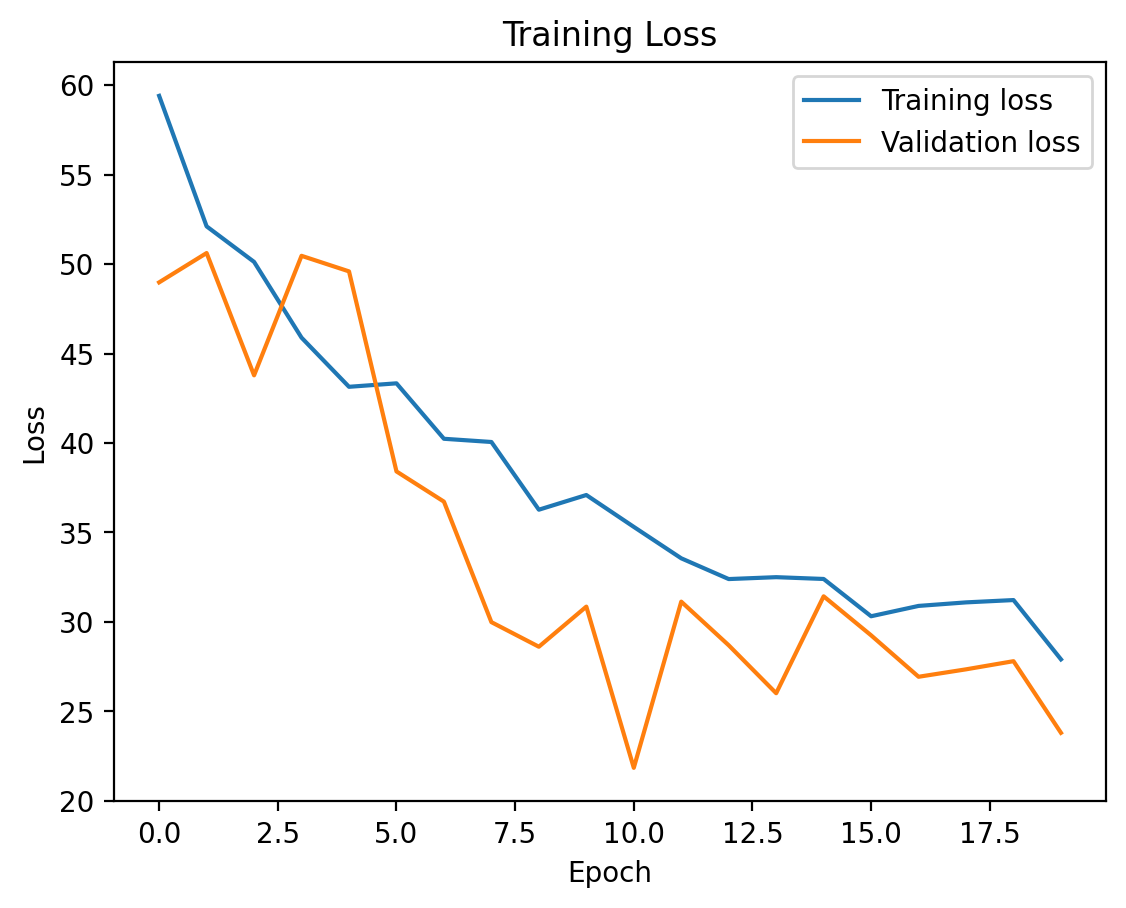

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_seq2seq_lstm(model, optimizer, criterion, 20)

We can see both losses going down quite a bit, which is always great news. Let's see the results after another 30 epochs:

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 21:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 27.61748113939839


Average Validation Loss: 28.754684066772462


Epoch 22:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 27.749508703908614


Average Validation Loss: 23.774492263793945


Epoch 23:: 100%|██████████| 31/31 [00:52<00:00,  1.71s/it]

Average Train Loss: 28.612557318902784


Average Validation Loss: 30.372077560424806


Epoch 24:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 29.30205726623535


Average Validation Loss: 24.433372688293456


Epoch 25:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 28.691245109804214


Average Validation Loss: 24.022361755371094


Epoch 26:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 27.563296225763136


Average Validation Loss: 24.23109016418457


Epoch 27:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]


Average Train Loss: 26.77032846020114
Average Validation Loss: 23.41617946624756


Epoch 28:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 26.61114618855138


Average Validation Loss: 25.90773124694824


Epoch 29:: 100%|██████████| 31/31 [00:57<00:00,  1.84s/it]


Average Train Loss: 29.608281350904896
Average Validation Loss: 24.093571662902832


Epoch 30:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 27.056053161621094


Average Validation Loss: 24.96705322265625


Epoch 31:: 100%|██████████| 31/31 [00:59<00:00,  1.92s/it]

Average Train Loss: 25.243907682357296


Average Validation Loss: 24.428591537475587


Epoch 32:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 23.84577594264861


Average Validation Loss: 24.540893745422363


Epoch 33:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 25.119025753390403


Average Validation Loss: 26.439769554138184


Epoch 34:: 100%|██████████| 31/31 [01:00<00:00,  1.94s/it]

Average Train Loss: 24.66125782074467


Average Validation Loss: 25.47830810546875


Epoch 35:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 23.81167128778273


Average Validation Loss: 25.946256256103517


Epoch 36:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 24.15807874741093


Average Validation Loss: 22.811984252929687


Epoch 37:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 24.168656810637444


Average Validation Loss: 21.93985767364502


Epoch 38:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]


Average Train Loss: 23.36957900754867
Average Validation Loss: 25.89554786682129


Epoch 39:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


Average Train Loss: 23.505631846766317
Average Validation Loss: 29.58304557800293


Epoch 40:: 100%|██████████| 31/31 [00:56<00:00,  1.84s/it]

Average Train Loss: 25.224970848329605


Average Validation Loss: 19.94608917236328


Epoch 41:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 24.24524467222152


Average Validation Loss: 21.148018455505373


Epoch 42:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 23.80657479070848


Average Validation Loss: 23.008582878112794


Epoch 43:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]

Average Train Loss: 22.99241035215316


Average Validation Loss: 21.1481990814209


Epoch 44:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 22.911054857315555


Average Validation Loss: 20.646810150146486


Epoch 45:: 100%|██████████| 31/31 [00:57<00:00,  1.84s/it]

Average Train Loss: 22.90739256335843


Average Validation Loss: 20.527098655700684


Epoch 46:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 23.980085726707213


Average Validation Loss: 22.40571174621582


Epoch 47:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 22.378696380123014


Average Validation Loss: 20.28722152709961


Epoch 48:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 23.923730173418598


Average Validation Loss: 19.40363483428955


Epoch 49:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]


Average Train Loss: 22.464601270614132
Average Validation Loss: 20.203609275817872


Epoch 50:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 21.869955893485777


Average Validation Loss: 22.88028564453125


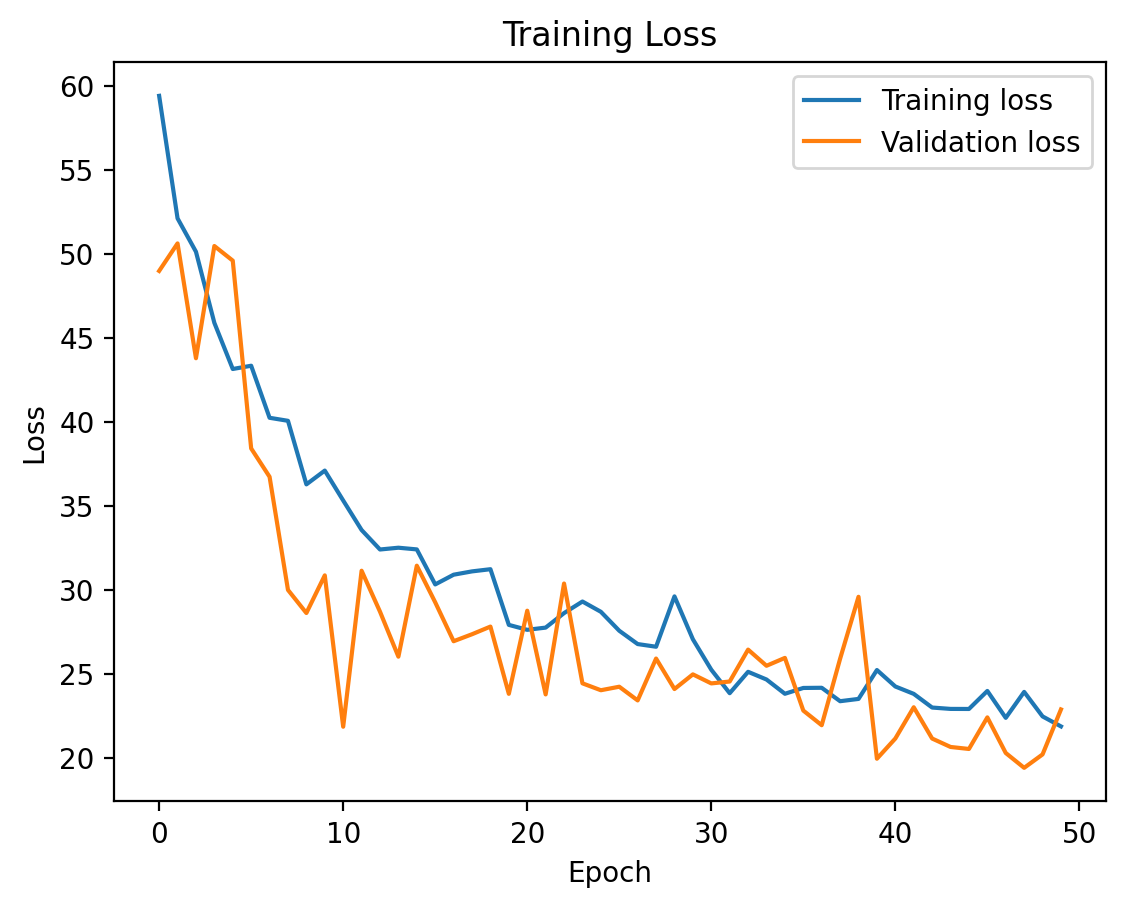

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_seq2seq_lstm(model, optimizer, criterion, 30, train_loss_history, val_loss_history)

Well, although it slowed down significantly, we can see a general downward trend. Let's do another 30 epochs and see what we can do from there:

Epoch 51:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 21.322882621519028


Average Validation Loss: 23.45250244140625


Epoch 52:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 22.432246669646233


Average Validation Loss: 26.323347091674805


Epoch 53:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 20.967795648882465


Average Validation Loss: 19.155003547668457


Epoch 54:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 21.299403932786756


Average Validation Loss: 20.254875946044923


Epoch 55:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 22.112548089796498


Average Validation Loss: 19.845536613464354


Epoch 56:: 100%|██████████| 31/31 [00:53<00:00,  1.74s/it]

Average Train Loss: 21.609470182849513


Average Validation Loss: 22.61482048034668


Epoch 57:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 22.08442106554585


Average Validation Loss: 22.28840866088867


Epoch 58:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 21.61346484768775


Average Validation Loss: 18.637153816223144


Epoch 59:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]


Average Train Loss: 20.47494436079456
Average Validation Loss: 21.023493385314943


Epoch 60:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 20.401969971195346


Average Validation Loss: 19.13710308074951


Epoch 61:: 100%|██████████| 31/31 [00:54<00:00,  1.75s/it]

Average Train Loss: 21.082534513165875


Average Validation Loss: 22.221450805664062


Epoch 62:: 100%|██████████| 31/31 [00:57<00:00,  1.87s/it]

Average Train Loss: 21.60106191327495


Average Validation Loss: 24.585391807556153


Epoch 63:: 100%|██████████| 31/31 [00:57<00:00,  1.87s/it]

Average Train Loss: 21.50979749618038


Average Validation Loss: 23.201077270507813


Epoch 64:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 23.919769779328377


Average Validation Loss: 19.612671089172363


Epoch 65:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 21.071248177559145


Average Validation Loss: 18.776170921325683


Epoch 66:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 20.97249400231146


Average Validation Loss: 20.790380668640136


Epoch 67:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 21.79442993287117


Average Validation Loss: 18.527386283874513


Epoch 68:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 22.50876795861029


Average Validation Loss: 20.616485595703125


Epoch 69:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]


Average Train Loss: 21.927246801314816
Average Validation Loss: 17.38756561279297


Epoch 70:: 100%|██████████| 31/31 [00:55<00:00,  1.81s/it]

Average Train Loss: 20.36138140770697


Average Validation Loss: 18.222370147705078


Epoch 71:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 20.127893109475412


Average Validation Loss: 18.5839204788208


Epoch 72:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 18.191377562861287


Average Validation Loss: 17.926608085632324


Epoch 73:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 18.082203768914745


Average Validation Loss: 23.61689682006836


Epoch 74:: 100%|██████████| 31/31 [00:57<00:00,  1.85s/it]

Average Train Loss: 19.64454907755698


Average Validation Loss: 17.766731452941894


Epoch 75:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 18.505878510013705


Average Validation Loss: 15.48979320526123


Epoch 76:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 19.17422842210339


Average Validation Loss: 18.45674419403076


Epoch 77:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]

Average Train Loss: 20.556828221967145


Average Validation Loss: 20.584942245483397


Epoch 78:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 19.617328059288763


Average Validation Loss: 16.307097911834717


Epoch 79:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]


Average Train Loss: 18.702709905562863
Average Validation Loss: 17.319001865386962


Epoch 80:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 20.941964426348285


Average Validation Loss: 19.592330932617188


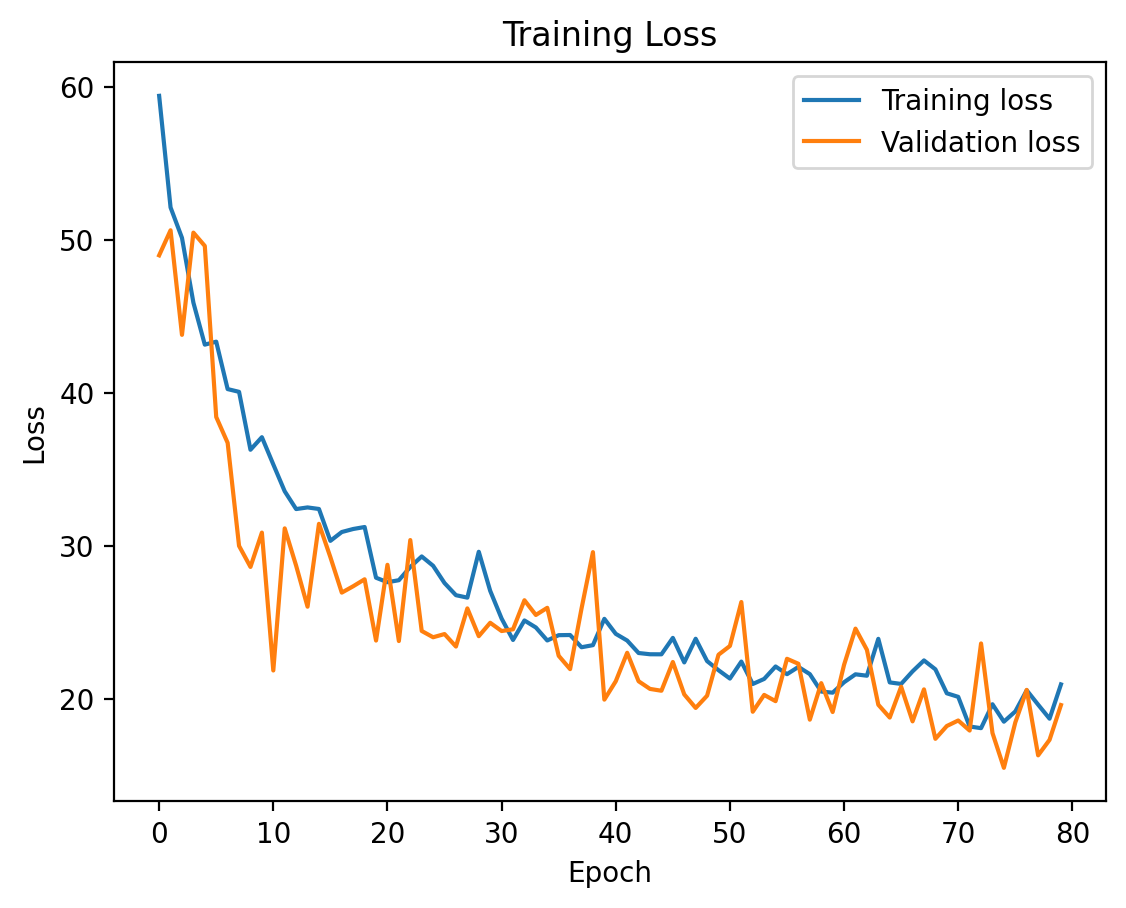

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_seq2seq_lstm(model, optimizer, criterion, 30, train_loss_history, val_loss_history)

The losses have slowed down, but they are still falling, let's finally do another 40 epochs to see if we can get even lower loss:

Epoch 81:: 100%|██████████| 31/31 [00:57<00:00,  1.87s/it]


Average Train Loss: 18.573843925229966
Average Validation Loss: 22.51130313873291


Epoch 82:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 18.788023264177383


Average Validation Loss: 17.930444145202635


Epoch 83:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 19.338508052210653


Average Validation Loss: 18.033142280578613


Epoch 84:: 100%|██████████| 31/31 [00:58<00:00,  1.89s/it]

Average Train Loss: 20.06558206004481


Average Validation Loss: 19.431178092956543


Epoch 85:: 100%|██████████| 31/31 [01:01<00:00,  1.99s/it]

Average Train Loss: 18.356602299597956


Average Validation Loss: 19.403493690490723


Epoch 86:: 100%|██████████| 31/31 [00:53<00:00,  1.73s/it]

Average Train Loss: 18.85710402457945


Average Validation Loss: 17.170484733581542


Epoch 87:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 18.29280053415606


Average Validation Loss: 16.582843589782716


Epoch 88:: 100%|██████████| 31/31 [00:54<00:00,  1.77s/it]

Average Train Loss: 20.147855604848555


Average Validation Loss: 17.300467491149902


Epoch 89:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]


Average Train Loss: 18.031666448039392
Average Validation Loss: 20.106297302246094


Epoch 90:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 17.717956119968044


Average Validation Loss: 16.107491302490235


Epoch 91:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 18.270659354425245


Average Validation Loss: 16.499877548217775


Epoch 92:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 19.29481109496086


Average Validation Loss: 15.786530494689941


Epoch 93:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 18.04734620740337


Average Validation Loss: 16.26607265472412


Epoch 94:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 19.129034565341087


Average Validation Loss: 14.059441661834716


Epoch 95:: 100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Average Train Loss: 17.46640383812689


Average Validation Loss: 17.16575927734375


Epoch 96:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 18.06026700235182


Average Validation Loss: 14.277747344970702


Epoch 97:: 100%|██████████| 31/31 [00:56<00:00,  1.83s/it]

Average Train Loss: 18.332986770137662


Average Validation Loss: 15.549618148803711


Epoch 98:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 18.657959476594


Average Validation Loss: 17.31436424255371


Epoch 99:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]


Average Train Loss: 17.992916753215173
Average Validation Loss: 14.5310791015625


Epoch 100:: 100%|██████████| 31/31 [00:57<00:00,  1.87s/it]

Average Train Loss: 17.774398403783


Average Validation Loss: 18.83076591491699


Epoch 101:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 16.318580935078284


Average Validation Loss: 16.81926441192627


Epoch 102:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]

Average Train Loss: 19.070629181400424


Average Validation Loss: 17.862808990478516


Epoch 103:: 100%|██████████| 31/31 [00:54<00:00,  1.76s/it]

Average Train Loss: 19.05099881079889


Average Validation Loss: 15.178659248352051


Epoch 104:: 100%|██████████| 31/31 [00:55<00:00,  1.81s/it]

Average Train Loss: 17.209872768771262


Average Validation Loss: 18.45707015991211


Epoch 105:: 100%|██████████| 31/31 [00:57<00:00,  1.87s/it]

Average Train Loss: 18.68928026383923


Average Validation Loss: 14.134460639953613


Epoch 106:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 18.01378837708504


Average Validation Loss: 15.578499221801758


Epoch 107:: 100%|██████████| 31/31 [00:55<00:00,  1.78s/it]

Average Train Loss: 17.306690262209983


Average Validation Loss: 15.20733585357666


Epoch 108:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 17.553839991169593


Average Validation Loss: 14.904654693603515


Epoch 109:: 100%|██████████| 31/31 [00:58<00:00,  1.87s/it]


Average Train Loss: 17.060578284725064
Average Validation Loss: 19.543054580688477


Epoch 110:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 17.07367782438955


Average Validation Loss: 21.674277687072752


Epoch 111:: 100%|██████████| 31/31 [00:57<00:00,  1.86s/it]

Average Train Loss: 17.949622215763217


Average Validation Loss: 15.025723648071288


Epoch 112:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 17.62760433073967


Average Validation Loss: 15.491540622711181


Epoch 113:: 100%|██████████| 31/31 [00:55<00:00,  1.80s/it]

Average Train Loss: 17.31754672142767


Average Validation Loss: 15.926024436950684


Epoch 114:: 100%|██████████| 31/31 [00:58<00:00,  1.90s/it]

Average Train Loss: 18.20508123213245


Average Validation Loss: 16.724185752868653


Epoch 115:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 19.086573016258978


Average Validation Loss: 18.987286376953126


Epoch 116:: 100%|██████████| 31/31 [00:56<00:00,  1.82s/it]

Average Train Loss: 18.271291978897587


Average Validation Loss: 16.745488357543945


Epoch 117:: 100%|██████████| 31/31 [00:56<00:00,  1.81s/it]

Average Train Loss: 18.41877854254938


Average Validation Loss: 14.75522575378418


Epoch 118:: 100%|██████████| 31/31 [00:55<00:00,  1.79s/it]

Average Train Loss: 16.944523226830267


Average Validation Loss: 18.79123764038086


Epoch 119:: 100%|██████████| 31/31 [00:56<00:00,  1.84s/it]


Average Train Loss: 19.018003002289802
Average Validation Loss: 15.098522186279297


Epoch 120:: 100%|██████████| 31/31 [00:58<00:00,  1.88s/it]

Average Train Loss: 17.89568310399209


Average Validation Loss: 17.994402503967287


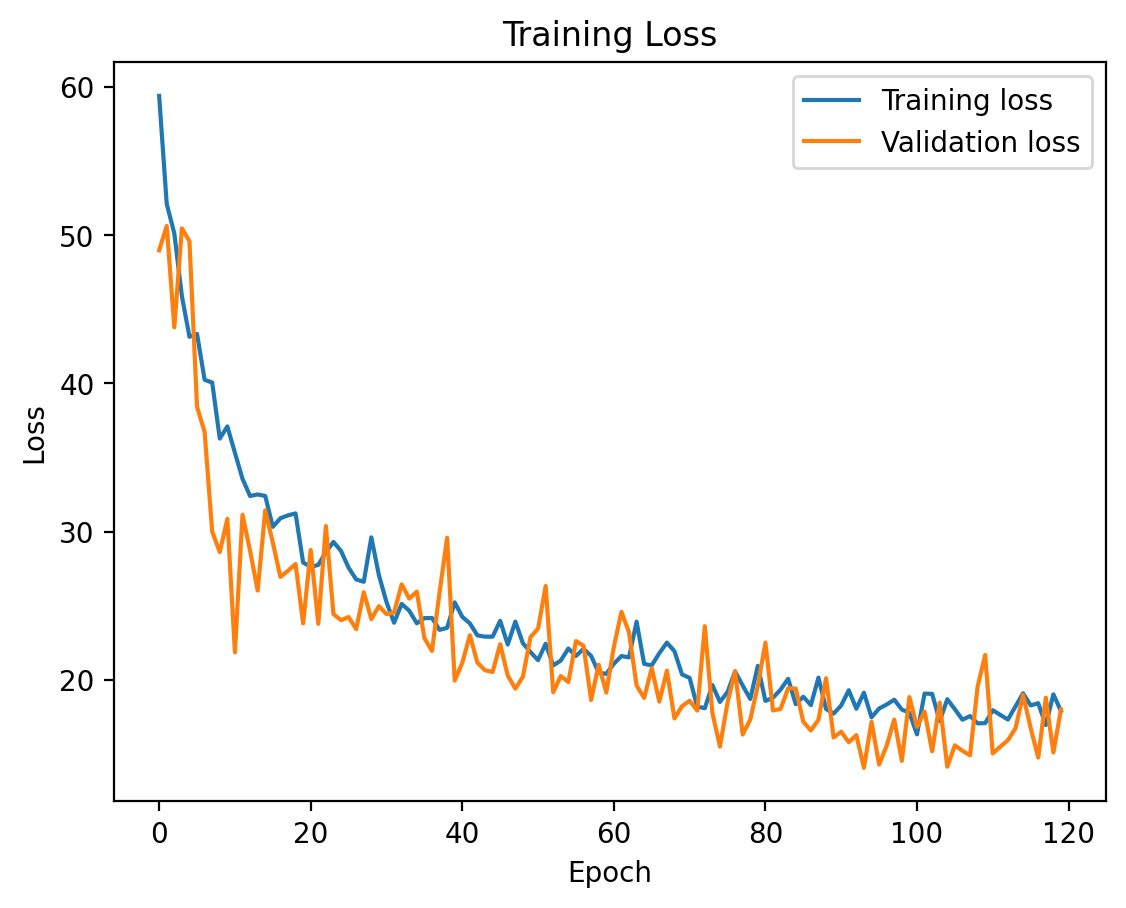

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss_history, val_loss_history = train_seq2seq_lstm(model, optimizer, criterion, 40, train_loss_history, val_loss_history)

There is no significant improvement in over 40 epochs so it's best if the training stops here.